My first Data Science project all by myself. Exciting!

In [19]:
# Loading data and initial Imports

import os, warnings, json, joblib
os.environ['SCIPY_ARRAY_API'] = '1'
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             classification_report, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
import xgboost as xgb

In [2]:
loan = pd.read_csv("../data/input/loan.csv")

df_loan = loan.copy()

eda = pd.read_parquet("../data/input/features_from_eda.parquet")
eda = eda.reset_index(drop=True)
loan = df_loan.reset_index(drop=True)

In [4]:
num_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
cat_cols = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Credit_History']

df = loan.copy()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

for col in ['ApplicantIncome','CoapplicantIncome','LoanAmount']:
    df[f'{col}_Log'] = np.log1p(df[col])

df['Total_Income']          = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Loan_to_Income_Ratio'] = df['LoanAmount'] / df['Total_Income']
df['Loan_per_Month']       = df['LoanAmount'] / (df['Loan_Amount_Term'] / 12)
df['Married_Credit'] = df['Married'].map({'Yes':1,'No':0}) * df['Credit_History']
df['Edu_Loan']       = df['Education'].map({'Graduate':1,'Not Graduate':0}) * df['LoanAmount']

bins = [0, 3000, 6000, 10000, 81000] 
labels = ['Low', 'Average', 'High', 'Very_High']
df['Income_Bin'] = pd.cut(df['Total_Income'], bins=bins, labels=labels, right=False)

target = 'Loan_Status'

baseline_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term',
                 'Gender','Married','Dependents','Education','Self_Employed',
                 'Property_Area','Credit_History', 'Income_Bin'] 

eda_cols = ['ApplicantIncome_Log','CoapplicantIncome_Log','LoanAmount_Log',
            'Total_Income','Loan_to_Income_Ratio','Loan_per_Month', 'Married_Credit',
            'Edu_Loan', 'Gender','Married','Dependents','Education',
            'Self_Employed','Property_Area','Credit_History', 'Income_Bin'] 

print(df.isna().sum())

Gender                   0
Married                  0
Dependents               0
Education                0
Self_Employed            0
ApplicantIncome          0
CoapplicantIncome        0
LoanAmount               0
Loan_Amount_Term         0
Credit_History           0
Property_Area            0
Loan_Status              0
ApplicantIncome_Log      0
CoapplicantIncome_Log    0
LoanAmount_Log           0
Total_Income             0
Loan_to_Income_Ratio     0
Loan_per_Month           0
Married_Credit           0
Edu_Loan                 0
Income_Bin               1
dtype: int64


In [5]:
target = 'Loan_Status'

nominal_cols = ['Gender', 'Married', 'Self_Employed', 'Credit_History', 'Property_Area']
ordinal_cols = ['Education']

baseline_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term',
                 'Gender','Married','Dependents','Education','Self_Employed','Property_Area','Credit_History']

eda_cols = ['ApplicantIncome_Log','CoapplicantIncome_Log','LoanAmount_Log',
            'Total_Income','Loan_to_Income_Ratio','Loan_per_Month',
            'Married_Credit','Edu_Loan',
            'Gender','Married','Dependents','Education',
            'Self_Employed','Property_Area','Credit_History']

def build_pipleline(cols):
    num = [c for c in cols
           if ('Log' in c or 'Ratio' in c or 'Month' in c or
               'Income' in c or 'Loan' in c or 'Term' in c)]
    nom = [c for c in cols if c in nominal_cols]
    ords = [c for c in cols if c in ordinal_cols]
    pre = ColumnTransformer([
        ('num', StandardScaler(), num),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nom),
        ('ord', OrdinalEncoder(), ords)
    ])
    
    # Corrected line
    model = ImbPipeline ([
        ('prep', pre),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
    ])
    return model

def split_and_train(df, cols):
    X = df[cols]
    y = df[target].map({'Y' : 1, 'N': 0})

    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)
    X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.43, stratify=y_tmp, random_state=42)

    return X_tr, X_val, X_te, y_tr, y_val, y_te

baseline_splits = split_and_train(df, baseline_cols)
eda_splits = split_and_train(df, eda_cols)

print("Baseline Columns: ", len(baseline_cols))
print("EDA Columns: ", len(eda_cols))


Baseline Columns:  11
EDA Columns:  15


In [24]:
clf1 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
clf2 = KNeighborsClassifier()
clf3 = lgb.LGBMClassifier(random_state=42)


preprocessor = build_pipleline(eda_cols).get_params()['prep']
ensemble_pipeline = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', VotingClassifier(
        estimators=[('lr', clf1), ('knn', clf2), ('lgbm', clf3)],
        voting='soft' 
    ))
])

models = {
    'LogReg': (LogisticRegression(max_iter=1000, solver='liblinear'),
               {'clf__C': [0.01, 0.1, 1, 10]}),
               
    'KNN':    (KNeighborsClassifier(),
               {'clf__n_neighbors': [3, 5, 7, 9, 11]}),
               
    'ANN':    (MLPClassifier(max_iter=1000, random_state=42),
               {'clf__hidden_layer_sizes': [(50,), (100,)],
                'clf__alpha': [0.001, 0.01]}),

    'LGBM':   (lgb.LGBMClassifier(random_state=42),
               {
                'clf__n_estimators': [100, 200],
                'clf__learning_rate': [0.01, 0.1],
                'clf__num_leaves': [20, 31, 40]
               }),
    'XGB':    (xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
               {
                'clf__n_estimators': [100, 200],
                'clf__learning_rate': [0.01, 0.1],
                'clf__max_depth': [3, 5, 7],
                'clf__subsample': [0.7, 1.0]
               }),
    'voting':  ( ensemble_pipeline,
               {
                'clf__lr__C': [0.1, 1.0, 10],
                'clf__knn__n_neighbors': [5, 7, 9],
                'clf__lgbm__n_estimators': [100, 200],
                'clf__lgbm__learning_rate': [0.01, 0.1],
                })
}

results = {}
for name, (estimator, grid) in models.items():
    
    if name == 'voting':
        X_tr, X_val, X_te, y_tr, y_val, y_te = eda_splits

        pipe = estimator

        gs = GridSearchCV(pipe, grid, cv=5, scoring='f1', n_jobs=-1)
        gs.fit(X_tr, y_tr)

        f1_val = f1_score(y_val, gs.predict(X_val))
        f1_te  = f1_score(y_te,  gs.predict(X_te))
        results[f"{name}_eda"] = (f1_val, f1_te)

    else:
        for key, splits in [('baseline', baseline_splits),
                            ('eda',      eda_splits)]:

            X_tr, X_val, X_te, y_tr, y_val, y_te = splits
            cols = baseline_cols if key == 'baseline' else eda_cols
 
            pipe = build_pipleline(cols)
            pipe.steps[-1] = ('clf', estimator) 

            gs = GridSearchCV(pipe, grid, cv=5, scoring='f1', n_jobs=-1)
            gs.fit(X_tr, y_tr)

            f1_val = f1_score(y_val, gs.predict(X_val))
            f1_te  = f1_score(y_te,  gs.predict(X_te))
            results[f"{name}_{key}"] = (f1_val, f1_te)

pd.DataFrame(results, index=["Val-F1","Test-F1"]).T.round(3)

[LightGBM] [Info] Number of positive: 274, number of negative: 274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 548, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 274, number of negative: 274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 548, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

,Val-F1,Test-F1
LogReg_baseline,0.805,0.832
LogReg_eda,0.792,0.892
KNN_baseline,0.719,0.756
KNN_eda,0.709,0.774
ANN_baseline,0.747,0.835
ANN_eda,0.783,0.780
LGBM_baseline,0.772,0.806
LGBM_eda,0.814,0.846
XGB_baseline,0.879,0.884
XGB_eda,0.886,0.900


In [25]:
best_key = max(results, key=lambda k: results[k][1])
model_name, feature_set = best_key.split('_')

if feature_set == 'baseline':
    X_tr, X_val, X_te, y_tr, y_val, y_te = baseline_splits
    cols = baseline_cols
else:
    X_tr, X_val, X_te, y_tr, y_val, y_te = eda_splits
    cols = eda_cols


best_estimator_object, best_grid = models[model_name]

pipeline = build_pipleline(cols)

pipeline.steps[-1] = ('clf', best_estimator_object)

best_model = GridSearchCV(
    pipeline,  
    best_grid, 
    cv=5,
    scoring='f1'
).fit(X_tr, y_tr)


joblib.dump(best_model.best_estimator_, "../models/best_loan_classifier.joblib")
print("Saved:", best_key, "with Test-F1 =", results[best_key][1])

Saved: XGB_eda with Test-F1 = 0.9



LogReg – BASELINE  (Test)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.69      0.63        29
           1       0.85      0.78      0.81        64

    accuracy                           0.75        93
   macro avg       0.72      0.74      0.72        93
weighted avg       0.77      0.75      0.76        93



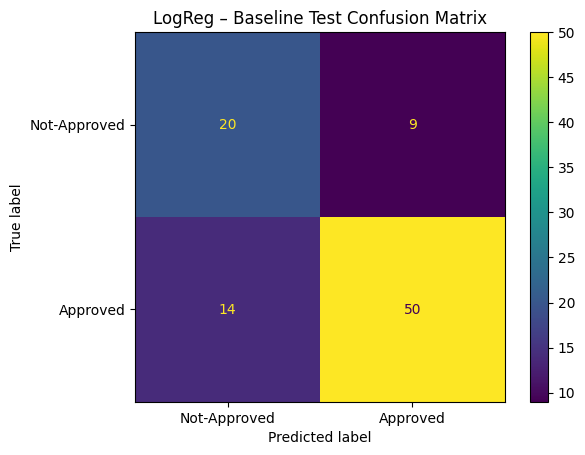


LogReg – EDA  (Test)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.66      0.68        29
           1       0.85      0.88      0.86        64

    accuracy                           0.81        93
   macro avg       0.78      0.77      0.77        93
weighted avg       0.80      0.81      0.80        93



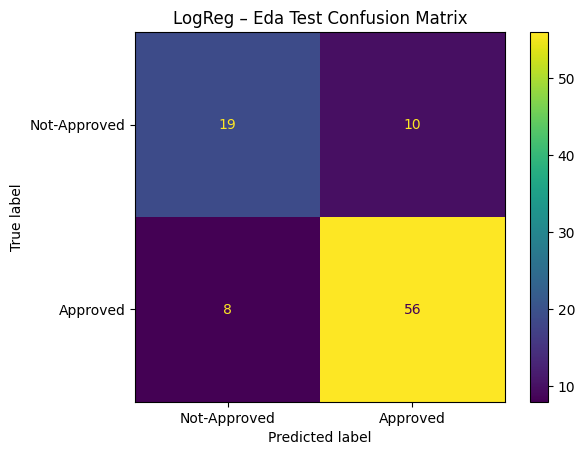


KNN – BASELINE  (Test)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        29
           1       0.81      0.75      0.78        64

    accuracy                           0.71        93
   macro avg       0.67      0.69      0.68        93
weighted avg       0.72      0.71      0.72        93



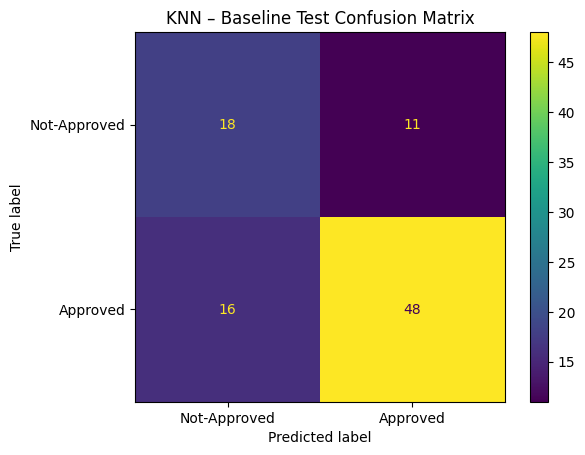


KNN – EDA  (Test)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.59      0.55        29
           1       0.80      0.75      0.77        64

    accuracy                           0.70        93
   macro avg       0.66      0.67      0.66        93
weighted avg       0.71      0.70      0.70        93



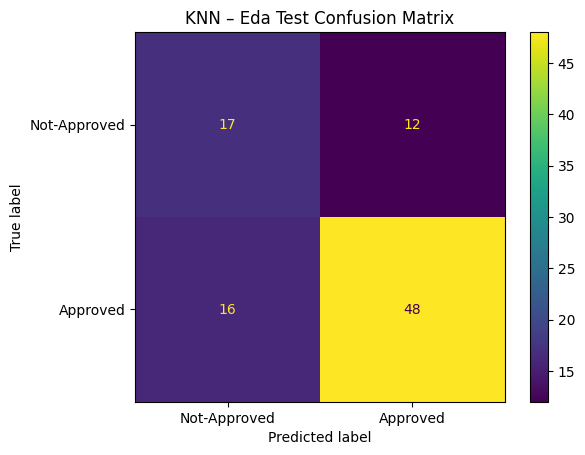


ANN – BASELINE  (Test)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        29
           1       0.83      0.86      0.85        64

    accuracy                           0.78        93
   macro avg       0.75      0.74      0.74        93
weighted avg       0.78      0.78      0.78        93



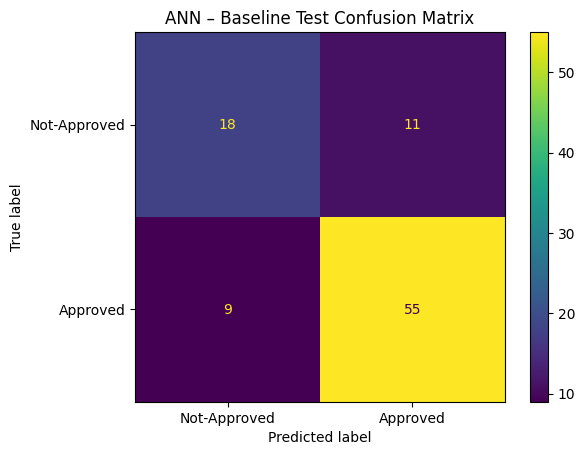


ANN – EDA  (Test)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.59      0.57        29
           1       0.81      0.78      0.79        64

    accuracy                           0.72        93
   macro avg       0.68      0.68      0.68        93
weighted avg       0.73      0.72      0.72        93



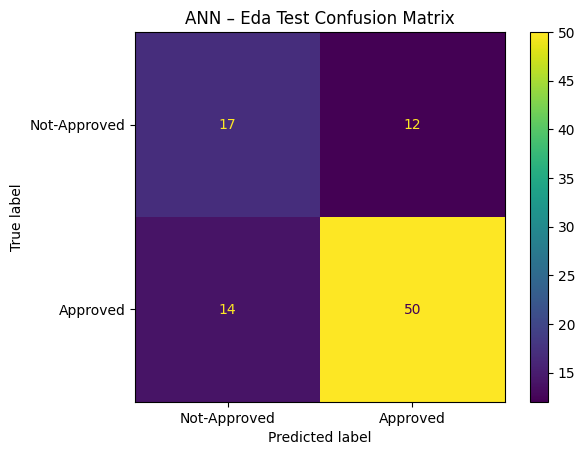

[LightGBM] [Info] Number of positive: 274, number of negative: 274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 548, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

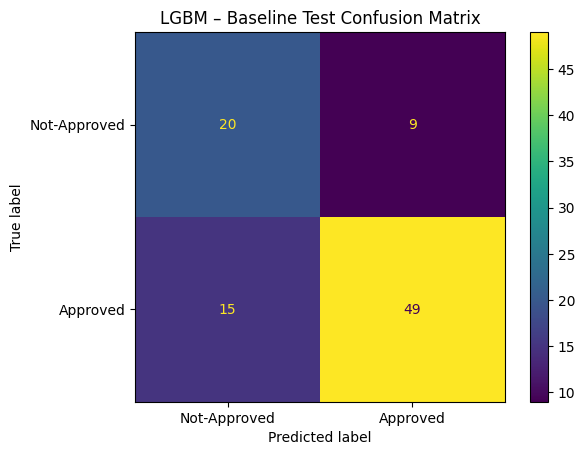

[LightGBM] [Info] Number of positive: 274, number of negative: 274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 548, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

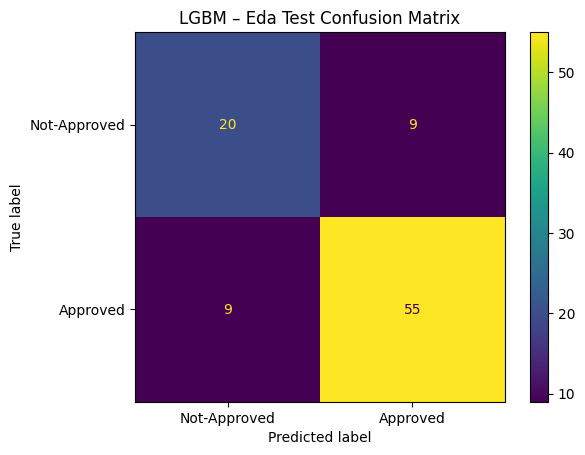


XGB – BASELINE  (Test)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.76      0.69        29
           1       0.88      0.80      0.84        64

    accuracy                           0.78        93
   macro avg       0.75      0.78      0.76        93
weighted avg       0.80      0.78      0.79        93



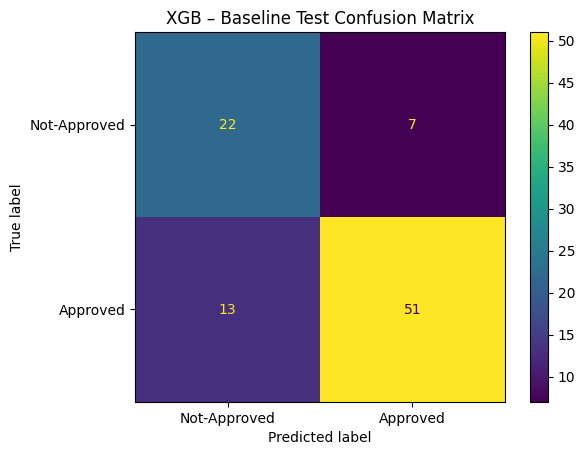


XGB – EDA  (Test)
---------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        29
           1       0.85      0.80      0.82        64

    accuracy                           0.76        93
   macro avg       0.73      0.74      0.73        93
weighted avg       0.77      0.76      0.77        93



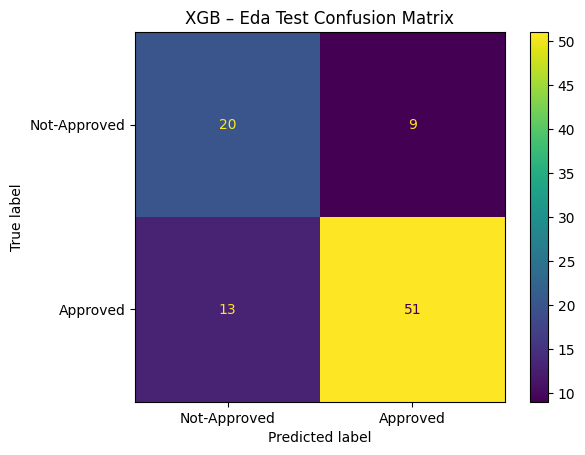

[LightGBM] [Info] Number of positive: 274, number of negative: 274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 548, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

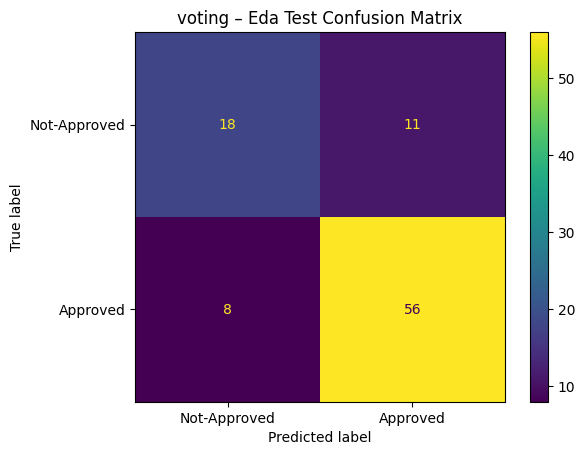

In [27]:
for name, (estimator, _) in models.items():

    if name == 'voting':
        key = 'eda'
        feat_cols = eda_cols
        X = df[feat_cols]
        y = df['Loan_Status'].map({'Y': 1, 'N': 0})

        X_tr, X_tmp, y_tr, y_tmp = train_test_split(
            X, y, test_size=0.35, stratify=y, random_state=42)
        X_val, X_te, y_val, y_te = train_test_split(
            X_tmp, y_tmp, test_size=0.4286, stratify=y_tmp, random_state=42)

        pipe = estimator
        pipe.fit(X_tr, y_tr)

        y_pred = pipe.predict(X_te)

        print(f"\n{name} – {key.upper()}  (Test)")
        print("-" * 45)
        print(classification_report(y_te, y_pred))
        ConfusionMatrixDisplay.from_predictions(
            y_te, y_pred, display_labels=['Not-Approved','Approved'])
        plt.title(f"{name} – {key.title()} Test Confusion Matrix")
        filename = f"confusion_matrix_{name}_{key}.png"
        plt.savefig(f'../data/output/{filename}')
        plt.show()

    else:
        for key in ['baseline', 'eda']:
            feat_cols = baseline_cols if key == 'baseline' else eda_cols
            X = df[feat_cols]
            y = df['Loan_Status'].map({'Y': 1, 'N': 0})

            X_tr, X_tmp, y_tr, y_tmp = train_test_split(
                X, y, test_size=0.35, stratify=y, random_state=42)
            X_val, X_te, y_val, y_te = train_test_split(
                X_tmp, y_tmp, test_size=0.4286, stratify=y_tmp, random_state=42)

            pipe = build_pipleline(feat_cols)
            pipe.steps[-1] = ('clf', estimator)
            pipe.fit(X_tr, y_tr)

            y_pred = pipe.predict(X_te)

            print(f"\n{name} – {key.upper()}  (Test)")
            print("-" * 45)
            print(classification_report(y_te, y_pred))
            ConfusionMatrixDisplay.from_predictions(
                y_te, y_pred, display_labels=['Not-Approved','Approved'])
            plt.title(f"{name} – {key.title()} Test Confusion Matrix")
            filename = f"confusion_matrix_{name}_{key}.png"
            plt.savefig(f'../data/output/{filename}')
            plt.show()

In [28]:
def predict_loan(new_application_dict, model_pipeline, feature_cols):

    df_new = pd.DataFrame([new_application_dict])

    for col in ['ApplicantIncome','CoapplicantIncome','LoanAmount']:
        df_new[f'{col}_Log'] = np.log1p(df_new[col])

    df_new['Total_Income']          = df_new['ApplicantIncome'] + df_new['CoapplicantIncome']
    df_new['Loan_to_Income_Ratio'] = df_new['LoanAmount'] / df_new['Total_Income']
    df_new['Loan_per_Month']       = df_new['LoanAmount'] / (df_new['Loan_Amount_Term'] / 12)
    df_new['Married_Credit']      = df_new['Married'].map({'Yes':1,'No':0}) * df_new['Credit_History']
    df_new['Edu_Loan']            = df_new['Education'].map({'Graduate':1,'Not Graduate':0}) * df_new['LoanAmount']

    pred = model_pipeline.predict(df_new)[0]
    prob = model_pipeline.predict_proba(df_new)[0, 1]

    print(f"Prediction: {'Approved' if pred else 'Not Approved'} (Confidence: {prob:.2%})")

In [29]:
new_application = {
    'Gender': 'Male',
    'Married': 'Yes',
    'Dependents': '1',
    'Education': 'Graduate',
    'Self_Employed': 'No',
    'ApplicantIncome': 5000,
    'CoapplicantIncome': 2000,
    'LoanAmount': 150,
    'Loan_Amount_Term': 360.0,
    'Credit_History': 1.0,
    'Property_Area': 'Urban'
}

predict_loan(new_application, best_model.best_estimator_, cols)

Prediction: Approved (Confidence: 60.23%)


In [31]:
new_application = {
    'Gender': 'Male',
    'Married': 'Yes',
    'Dependents': '1',
    'Education': 'Graduate',
    'Self_Employed': 'No',
    'ApplicantIncome': 5000,
    'CoapplicantIncome': 2000,
    'LoanAmount': 150,
    'Loan_Amount_Term': 360.0,
    'Credit_History': 1.0,
    'Property_Area': 'Urban'
}

df_new = pd.DataFrame([new_application])

for col in ['ApplicantIncome','CoapplicantIncome','LoanAmount']:
    df_new[f'{col}_Log'] = np.log1p(df_new[col])

df_new['Total_Income']          = df_new['ApplicantIncome'] + df_new['CoapplicantIncome']
df_new['Loan_to_Income_Ratio'] = df_new['LoanAmount'] / df_new['Total_Income']
df_new['Loan_per_Month']        = df_new['LoanAmount'] / (df_new['Loan_Amount_Term'] / 12)
df_new['Married_Credit']        = df_new['Married'].map({'Yes':1,'No':0}) * df_new['Credit_History']
df_new['Edu_Loan']              = df_new['Education'].map({'Graduate':1,'Not Graduate':0}) * df_new['LoanAmount']


for model_name, (estimator, grid) in models.items():

    if model_name == 'voting':
        print(f"\nModel: {model_name} (using 'eda' features)")

        pipeline = estimator
        X_tr, _, _, y_tr, _, _ = eda_splits
        
        gs_model = GridSearchCV(pipeline, grid, cv=5, scoring='f1', n_jobs=-1)
        gs_model.fit(X_tr, y_tr)

        final_estimator_pipeline = gs_model.best_estimator_

        pred = final_estimator_pipeline.predict(df_new[eda_cols])[0]
        prob = final_estimator_pipeline.predict_proba(df_new[eda_cols])[0, 1]

        print(f"Prediction: {'Approved' if pred else 'Not Approved'}")
        print(f"Confidence (Approval Probability): {prob:.2%}")

    else:
        baseline_score = results.get(f'{model_name}_baseline', (0, -1))[1]
        eda_score      = results.get(f'{model_name}_eda', (0, -1))[1]

        if eda_score > baseline_score:
            feature_set = 'eda'
            cols = eda_cols
            X_tr, _, _, y_tr, _, _ = eda_splits
        else:
            feature_set = 'baseline'
            cols = baseline_cols
            X_tr, _, _, y_tr, _, _ = baseline_splits
        
        print(f"\nModel: {model_name} (using '{feature_set}' features)")
        pipeline = build_pipleline(cols)
        pipeline.steps[-1] = ('clf', estimator)

        gs_model = GridSearchCV(pipeline, grid, cv=5, scoring='f1', n_jobs=-1)
        gs_model.fit(X_tr, y_tr)

        final_estimator_pipeline = gs_model.best_estimator_

        pred = final_estimator_pipeline.predict(df_new[cols])[0]
        prob = final_estimator_pipeline.predict_proba(df_new[cols])[0, 1]

        print(f"Prediction: {'Approved' if pred else 'Not Approved'}")
        print(f"Confidence (Approval Probability): {prob:.2%}")


Model: LogReg (using 'eda' features)
Prediction: Approved
Confidence (Approval Probability): 56.66%

Model: KNN (using 'eda' features)
Prediction: Not Approved
Confidence (Approval Probability): 20.00%

Model: ANN (using 'baseline' features)
Prediction: Not Approved
Confidence (Approval Probability): 46.18%

Model: LGBM (using 'eda' features)
[LightGBM] [Info] Number of positive: 274, number of negative: 274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 548, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Prediction: Approved
Confidence (Approval Probability): 50.43%

Model: XGB (using 'eda' features)
Prediction: Approved
Confidence (Approval Probability): 60.23%

Model: voting (using 'eda' features)
[LightGBM] [Info] Numb

In [32]:
from sklearn.ensemble import StackingClassifier
base_estimators = [
    ('lgbm', lgb.LGBMClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=7))
]

meta_model = LogisticRegression(max_iter=1000, solver='liblinear')

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5
)

preprocessor = build_pipleline(eda_cols).get_params()['prep']
stacking_pipeline = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', stacking_clf)
])

models['Stacking'] = (
    stacking_pipeline,
    {} 
)

In [33]:
num_features = [c for c in X.columns if X[c].dtype != 'object' and X[c].dtype.name != 'category']
cat_features = [c for c in X.columns if X[c].dtype == 'object' or X[c].dtype.name == 'category']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)])

lgbm_pipeline = ImbPipeline([
    ('prep', preprocessor), ('smote', SMOTE(random_state=42)),
    ('clf', lgb.LGBMClassifier(random_state=42))])

voting_pipeline = ImbPipeline([
    ('prep', preprocessor), ('smote', SMOTE(random_state=42)),
    ('clf', VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, solver='liblinear')),
            ('lgbm', lgb.LGBMClassifier(random_state=42))
        ], voting='soft'))
])

stacking_pipeline = ImbPipeline([
    ('prep', preprocessor), ('smote', SMOTE(random_state=42)),
    ('clf', StackingClassifier(
        estimators=[
            ('lgbm', lgb.LGBMClassifier(n_estimators=100, random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=7))
        ],
        final_estimator=LogisticRegression(), cv=5))
])

final_models = {
    "LightGBM": lgbm_pipeline,
    "Voting": voting_pipeline,
    "Stacking": stacking_pipeline
}


new_application = {
    'Gender': 'Male', 'Married': 'Yes', 'Dependents': '1', 'Education': 'Graduate',
    'Self_Employed': 'No', 'ApplicantIncome': 5000, 'CoapplicantIncome': 2000,
    'LoanAmount': 150, 'Loan_Amount_Term': 360.0, 'Credit_History': 1.0,
    'Property_Area': 'Urban'
}

df_new = pd.DataFrame([new_application])

for col in ['ApplicantIncome','CoapplicantIncome','LoanAmount']:
    df_new[f'{col}_Log'] = np.log1p(df_new[col])
df_new['Total_Income'] = df_new['ApplicantIncome'] + df_new['CoapplicantIncome']
df_new['Loan_to_Income_Ratio'] = df_new['LoanAmount'] / df_new['Total_Income']
df_new['Loan_per_Month'] = df_new['LoanAmount'] / (df_new['Loan_Amount_Term'] / 12)
bins = [0, 3000, 6000, 10000, 81000]
labels = ['Low', 'Average', 'High', 'Very_High']
df_new['Income_Bin'] = pd.cut(df_new['Total_Income'], bins=bins, labels=labels, right=False)
df_new['Married_Credit'] = df_new['Married'].map({'Yes':1,'No':0}) * df_new['Credit_History']

df_new['Edu_Loan']       = df_new['Education'].map({'Graduate':1,'Not Graduate':0}) * df_new['LoanAmount']
print("\n--- Checking Final Model Predictions ---")
for name, model in final_models.items():
    model.fit(X, y)

    pred = model.predict(df_new)[0]
    prob = model.predict_proba(df_new)[0, 1]

    print(f"\nModel: {name}")
    print(f"Prediction: {'Approved' if pred else 'Not Approved'} (Confidence: {prob:.2%})")


--- Checking Final Model Predictions ---
[LightGBM] [Info] Number of positive: 422, number of negative: 422
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1893
[LightGBM] [Info] Number of data points in the train set: 844, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
